### Adaptive-DDTO Demo

The following notebook illustrates a step-by-step scenario of Adaptive-DDTO applied to the quadcopter landing scenario with randomized targets in a region of interest $R_{\mathrm{ROI}}$.

### Setup

Import dependency files and set simulation parameters.

In [1]:
# ..:: Imports ::..
include("setup.jl")
include("params.jl")
include("utils_control.jl")
include("utils_addto.jl")
include("utils_percep.jl")
include("solve_optimal.jl")
include("solve_ddto.jl")

# ..:: Simulation parameters ::..
Δt_sim   = 0.01      # [s] Simulation integration time-step
Δt_print = 1.        # [s] Simulation printing update time-step
R_ROI    = 50.       # [m] Radius of the region of interest for targets
h_cut    = 50.       # [m] Altitude condition to commit to best target
h_term   = 1.        # [m] Altitude condition to terminate descent phase
h_eps    = 1.        # [m] Acceptable altitude error in termination condition
r0       = [0,0,150] # [m] Initial position (NED frame)
v0       = [0,0,0]   # [m/s] Initial velocity (NED frame)

# ..:: Helper functions ::..
ct_dyn = (t,x,traj) -> quad.A_c*x + quad.B_c*optimal_controller(t,x,traj) + quad.p_c # Continuous-time dynamics
;

### Simulate

Full simulation of Adaptive-DDTO landing routine, with a descriptive output of simulation updates.

In [ ]:
# ..:: Sim Initialization ::..

# Initialize the quadcopter vehicle
quad = Lander()

# Set randomization seed
Random.seed!(0)

# Override the quadcopter's initial conditions
quad.r0 = r0
quad.v0 = v0

# Obtain N_max landing targets from perception stack
sim_acquire_new_targets!(quad, R_ROI)

# Simulation status
sim_cur_iter    = 0
sim_cur_time    = 0.0
sim_cur_state   = vcat(quad.r0, quad.v0)
sim_cur_control = zeros(quad.m)
sim_num_ddto    = 0

# Guidance
guid_cur_opt    = FailedSolution() # Most recently-computed optimal solution set
guid_cur_ddto   = EmptyDDTOSolution(quad.n_targs) # Most recently-computed DDTO solution set
guid_cur_traj   = FailedSolution() # Current guidance solution to track
guid_cur_time   = 0.0 # Current time in guidance solution
guid_prev_ddto  = EmptyDDTOSolution(quad.n_targs)
guid_defer_targ = -1 # Next deferred target in consideration (tag number)
guid_defer_time = 1.e6 # Time until branch point to next deferred target
guid_lock_time  = 1.e6 # Time at which guidance lock was activated

# Flags
flag_update_ddto         = true
flag_log_ddto_results    = false # If set to true, log DDTO results
flag_guid_lock_activated = false # If set to true, Adaptive-DDTO will be disabled and guidance will fix to the best target at the current time
flag_descent_complete    = false # If set to true, signals the end of the simulation/descent phase
flag_guid_lock_staged    = false # If set to true, stage a guidance lock

# Other variables
time_last_print = 0.0
λ_targs_org = quad.λ_targs

# Initialize results storage containers
results_guid_update_branches = Vector{Vector{BranchSolution}}(undef,0)
results_guid_update_trajs    = Array{Solution}(undef, 0)
results_guid_update_time     = CVector(undef, 0)
results_sim_time             = CVector(undef, 0)
results_sim_state            = CMatrix(undef, quad.n, 0)
results_sim_control          = CMatrix(undef, quad.m, 0)
results_targs_radii          = CMatrix(undef, quad.n_targs_max, 0)
results_targs_status         = CMatrix(undef, quad.n_targs_max, 0)
results_targs_positions      = Array{CMatrix}(undef, 0)

# Initial print statements
println("=== Beginning Simulation ===")
@printf("Time: %.2f s, Alt: %.2f m, Number of targets: %i\n", sim_cur_time, sim_cur_state[3], quad.n_targs)

# ..:: Main Sim Loop ::..
while !flag_descent_complete

    # Compute new DDTO guidance tree (if staged to do so)
    if flag_update_ddto && !flag_guid_lock_activated

        # Obtain (N_max - N_current) new targets from perception stack
        sim_acquire_new_targets!(quad, R_ROI)

        # Set guidance initial conditions as current sim state
        quad.r0 = sim_cur_state[1:3]
        quad.v0 = sim_cur_state[4:6]

        # Guidance solving
        try
            guid_cur_opt,guid_cur_ddto = solve_ddto_stack(quad) # Compute DDTO stack solution
        catch e
            @printf("---> DDTO ERROR [%.2f s]: %s\n", sim_cur_time, e)
            @printf("---> UPDATE [%.2f s]: Guidance lock staged [DDTO computation unsuccessful -- contingency activated!]\n", sim_cur_time)
            guid_cur_ddto = guid_prev_ddto
            flag_guid_lock_staged = true
        end
        guid_prev_ddto = copy(guid_cur_ddto)
        sim_num_ddto += 1

        if !flag_guid_lock_staged
            guid_cur_traj = extract_trunk_segment(quad, guid_cur_ddto) # Track the trunk of DDTO by default
            @printf("---> UPDATE [%.2f s]: DDTO solution successfully recomputed [tracking trunk segment]\n", sim_cur_time)
 
            # Parameter updates
            guid_cur_time = 0.0 # Reset guidance time to zero
            guid_defer_targ = quad.λ_targs[1]
            guid_defer_time = guid_cur_ddto[guid_defer_targ].idx_dd * quad.Δt 
            λ_targs_org = quad.λ_targs

            # If trunk segment has zero length (no deferring could take place),
            # lock guidance to the best target at the current point in time (last index of last DDTO branch solution)
            # as a contingency measure
            if length(guid_cur_traj.t) == 0
                @printf("---> UPDATE [%.2f s]: Guidance lock staged [DDTO deferral was not possible -- contingency activated!]\n", sim_cur_time)
                flag_guid_lock_staged = true
            end
        end

        # Flag updates
        flag_update_ddto = false
        flag_log_ddto_results = true
    end
    
    # Check for unsafe targets (radii check)
    if !flag_guid_lock_activated
        cur_targs = copy(quad.T_targs)
        for targ in cur_targs
            targ_idx = findfirst(i->i==targ, quad.T_targs)

            # Remove target if unsafe
            if quad.R_targs[targ_idx] <= quad.R_targs_min
                @printf("---> UPDATE [%.2f s]: Removing target %i [bounding radius below the minimum threshold]\n", sim_cur_time, targ)
                remove_ddto_target!(quad, targ)

                # If this target was queued for deferral, move to next target for deferral
                if targ == guid_defer_targ
                    guid_defer_targ = quad.λ_targs[1] # Add the next target in the queue to consideration for deferral
                    guid_defer_time += guid_cur_ddto[1].idx_dd * quad.Δt
                end
            end

            # Reached minimum target threshold
            if (quad.n_targs <= 2) || (quad.n_targs <= quad.n_targs_min)
                @printf("---> UPDATE [%.2f s]: DDTO recomputation staged [target set count below the minimum threshold]\n", sim_cur_time)
                flag_update_ddto = true
                break
            end
        end
    end

    # Check for branch switching
    if (guid_cur_time >= guid_defer_time) && !flag_guid_lock_activated
        while guid_cur_time >= guid_defer_time # Ready to determine switch

            # Determine if we should switch or not
            switch_branch = switch_decision(quad, guid_defer_targ)

            # Engage switch by staging DDTO update
            if switch_branch
                @printf("---> UPDATE [%.2f s]: DDTO recomputation staged [chose to defer to target %i]\n", sim_cur_time, guid_defer_targ)

                # Remove all targets except for switch target (`guid_defer_targ`)
                other_targs = copy(quad.T_targs)
                deleteat!(other_targs, findfirst(i->i==guid_defer_targ, other_targs))
                for targ in other_targs
                    remove_ddto_target!(quad, targ)
                end

                flag_update_ddto = true
                break

            # Remove the current target for deferral and go to the next one
            else
                @printf("---> UPDATE [%.2f s]: Removing target %i [chose to stay on trunk segment]\n", sim_cur_time, guid_defer_targ)
                remove_ddto_target!(quad, guid_defer_targ) # Remove the target that was in consideration for deferral
                guid_defer_targ = quad.λ_targs[1] # Add the next target in the queue to consideration for deferral
                guid_defer_time += guid_cur_ddto[1].idx_dd * quad.Δt # Iterate 
            end

            # Reached minimum target threshold
            if (quad.n_targs <= 2) || (quad.n_targs <= quad.n_targs_min)
                @printf("---> UPDATE [%.2f s]: DDTO recomputation staged [target set count below the minimum threshold]\n", sim_cur_time)
                flag_update_ddto = true
                break
            end
        end
    end

    # Update DDTO-locked target parameters
    sim_update_locked_targets!(quad)

    # Check if we have reached the cutoff altitude
    if sim_cur_state[3] <= h_cut && !flag_guid_lock_activated
        @printf("---> UPDATE [%.2f s]: Guidance lock staged [Cutoff altitude reached!]\n", sim_cur_time)
        flag_guid_lock_staged = true
    end

    # Lock guidance to best current target if necessary
    if flag_guid_lock_staged
        
        # Determine the current "best" target in terms of radius and obtain the corresponding trajectory
        targ_best_idx = argmax(quad.R_targs)
        targ_best = quad.T_targs[targ_best_idx]
        λ_best_idx = findfirst(i->i==targ_best, λ_targs_org)
        guid_cur_traj = extract_guid_lock_traj(quad, guid_cur_ddto, λ_best_idx, targ_best, λ_targs_org)
        
        # Parameter updates
        guid_defer_targ = targ_best
        guid_defer_time = 1e6
        flag_guid_lock_activated = true
        flag_guid_lock_staged = false
        flag_log_ddto_results = true
        guid_lock_time = sim_cur_time
        @printf("---> UPDATE [%.2f s]: Guidance locked to target %i\n", sim_cur_time, guid_defer_targ)

        # Remove all targets except for locked target (`guid_defer_targ`)
        other_targs = copy(quad.T_targs)
        deleteat!(other_targs, findfirst(i->i==guid_defer_targ, other_targs))
        for targ in other_targs
            remove_ddto_target!(quad, targ)
        end
    end

    # Integrate the currently-tracked guidance trajectory for one time-step
    cur_ct_dyn = (t,x) -> ct_dyn(t,x,guid_cur_traj)
    sim_cur_control = optimal_controller(guid_cur_time, sim_cur_state, guid_cur_traj)
    sim_cur_state = rk4_step(sim_cur_state, cur_ct_dyn, guid_cur_time, Δt_sim)
    sim_cur_time  += Δt_sim
    guid_cur_time += Δt_sim

    # Print sim status update(s)
    if (sim_cur_time - time_last_print) >= Δt_print
        defer_time_remaining = guid_defer_time - guid_cur_time
        if !flag_guid_lock_activated
            @printf("Time: %.2f s, Alt: %.2f m, Number of targets: %i, Next deferred target: %i (%.2f s remaining)\n", sim_cur_time, sim_cur_state[3], quad.n_targs, guid_defer_targ, defer_time_remaining)
        else
            @printf("Time: %.2f s, Alt: %.2f m, Guidance locked to target %i!\n", sim_cur_time, sim_cur_state[3], guid_defer_targ)
        end
        # @printf("---> Debug: Applying control [%.2f, %.2f, %.2f]\n", sim_cur_control[1], sim_cur_control[2], sim_cur_control[3])
        time_last_print = sim_cur_time
    end

    # Log continuous sim results
    results_sim_state   = hcat(results_sim_state, sim_cur_state)
    results_sim_control = hcat(results_sim_control, sim_cur_control)
    append!(results_sim_time, sim_cur_time)

    # Log current target radii (if a target index is unallocated, insert -Inf)
    sim_cur_radii = fill(-Inf, quad.n_targs_max)
    sim_cur_radii[quad.T_targs] = quad.R_targs
    results_targs_radii = hcat(results_targs_radii, sim_cur_radii)
    
    # Log current target positions (if a target index is unallocated, insert -Inf)
    sim_cur_targ_pos = -Inf * ones(3, quad.n_targs_max)
    sim_cur_targ_pos[:,quad.T_targs] = quad.rf_targs
    append!(results_targs_positions, [sim_cur_targ_pos])

    # Log target status (1 = valid, 0 = lost)
    targs_status = zeros(quad.n_targs_max)
    for k=1:quad.n_targs_max
        if k in quad.T_targs
            targs_status[k] = 1
        end
    end
    results_targs_status = hcat(results_targs_status, targs_status)
    
    # Log conditional sim results (DDTO)
    if flag_log_ddto_results
        # Log DDTO branches
        if !flag_guid_lock_activated
            branch_sols = Array{BranchSolution}(undef,quad.n_targs_max)
            T_targs_branch = collect(1:quad.n_targs_max)
            for k = 1:quad.n_targs_max
                targ_idx = findfirst(τ->τ==λ_targs_org[k], T_targs_branch)
                branch_sols[λ_targs_org[k]] = BranchSolution(guid_cur_ddto[k].targ_sols[targ_idx], guid_cur_ddto[k].cost_dd, guid_cur_ddto[k].idx_dd, sim_num_ddto)
                deleteat!(T_targs_branch, targ_idx)
            end
            push!(results_guid_update_branches, branch_sols)
        end
        
        # Log other data
        append!(results_guid_update_trajs, [guid_cur_traj])
        append!(results_guid_update_time, sim_cur_time)
        flag_log_ddto_results = false
    end

    # Terminate sim if we reach the phase completion condition
    if sim_cur_state[3] <= (h_term + h_eps)
        flag_descent_complete = true
        @printf("---> UPDATE [%.2f s]: Terminal altitude condition reached -- landing successful!\n", sim_cur_time)
    end
    if sim_cur_time >= 100
        display("Simulation ran for too long, exiting...")
        flag_descent_complete = true
    end
end

# ..:: Log resulting sim time/state/control into a `Solution` object ::..
t_sim = results_sim_time
r_sim = results_sim_state[1:3,:]
v_sim = results_sim_state[4:6,:]
T_sim = results_sim_control[1:3,:]
Γ_sim = results_sim_control[4,:]
cost_sim = sum(Γ_sim) * Δt_sim
T_nrm_sim = CVector([norm(T_sim[:,k],2) for k=1:length(Γ_sim)])
γ_sim     = CVector([acos(dot(T_sim[:,k],e_z)/norm(T_sim[:,k],2)) for k=1:length(Γ_sim)])
results_sim_sol = Solution(t_sim, r_sim, v_sim, T_sim, Γ_sim, cost_sim, T_nrm_sim, γ_sim)
;

### Plots

In [14]:
include("plots_utils.jl")
include("plots_core.jl")
@pyimport matplotlib.animation as animation
@pyimport mpl_toolkits as mpl
set_fonts()
set_fonts()
pygui(false)
;

### Landing replay animation

The following function will create an animated replay of the landing scenario. Notably:
- The black line represents the simulated path of the quadcopter up to that point in time.
- The gray line represents the deferrable segment of the current DDTO solution.
- The multicolored lines represent the branches of the current DDTO solution (with a diamond marker for the corresponding branch point).
- When a target is lost, it will be colored red and fade out.
- When only one target remains, the guidance lock condition has been triggered (the guidance up to landing will be colored gray).

Number of frames processed: 10


C:\Users\sbuck\.julia\conda\3\x86_64\lib\site-packages\matplotlib\transforms.py:2066: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[0, 1] *= sx
C:\Users\sbuck\.julia\conda\3\x86_64\lib\site-packages\matplotlib\transforms.py:2067: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[0, 2] *= sx
C:\Users\sbuck\.julia\conda\3\x86_64\lib\site-packages\matplotlib\transforms.py:2068: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[1, 0] *= sy
C:\Users\sbuck\.julia\conda\3\x86_64\lib\site-packages\matplotlib\transforms.py:2070: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx[1, 2] *= sy


Number of frames processed: 20
Number of frames processed: 30
Number of frames processed: 40
Number of frames processed: 50
Number of frames processed: 60
Number of frames processed: 70
Number of frames processed: 80
Number of frames processed: 90
Number of frames processed: 100
Number of frames processed: 110
Number of frames processed: 120
Number of frames processed: 130
Number of frames processed: 140
Number of frames processed: 150
Number of frames processed: 160
Number of frames processed: 170
Number of frames processed: 180
Number of frames processed: 190
Number of frames processed: 200
Number of frames processed: 210
Number of frames processed: 220
Number of frames processed: 230
Number of frames processed: 240
Number of frames processed: 250
Number of frames processed: 260
Number of frames processed: 270
Number of frames processed: 280
Number of frames processed: 290
Number of frames processed: 300
Number of frames processed: 310
Number of frames processed: 320
Number of frames

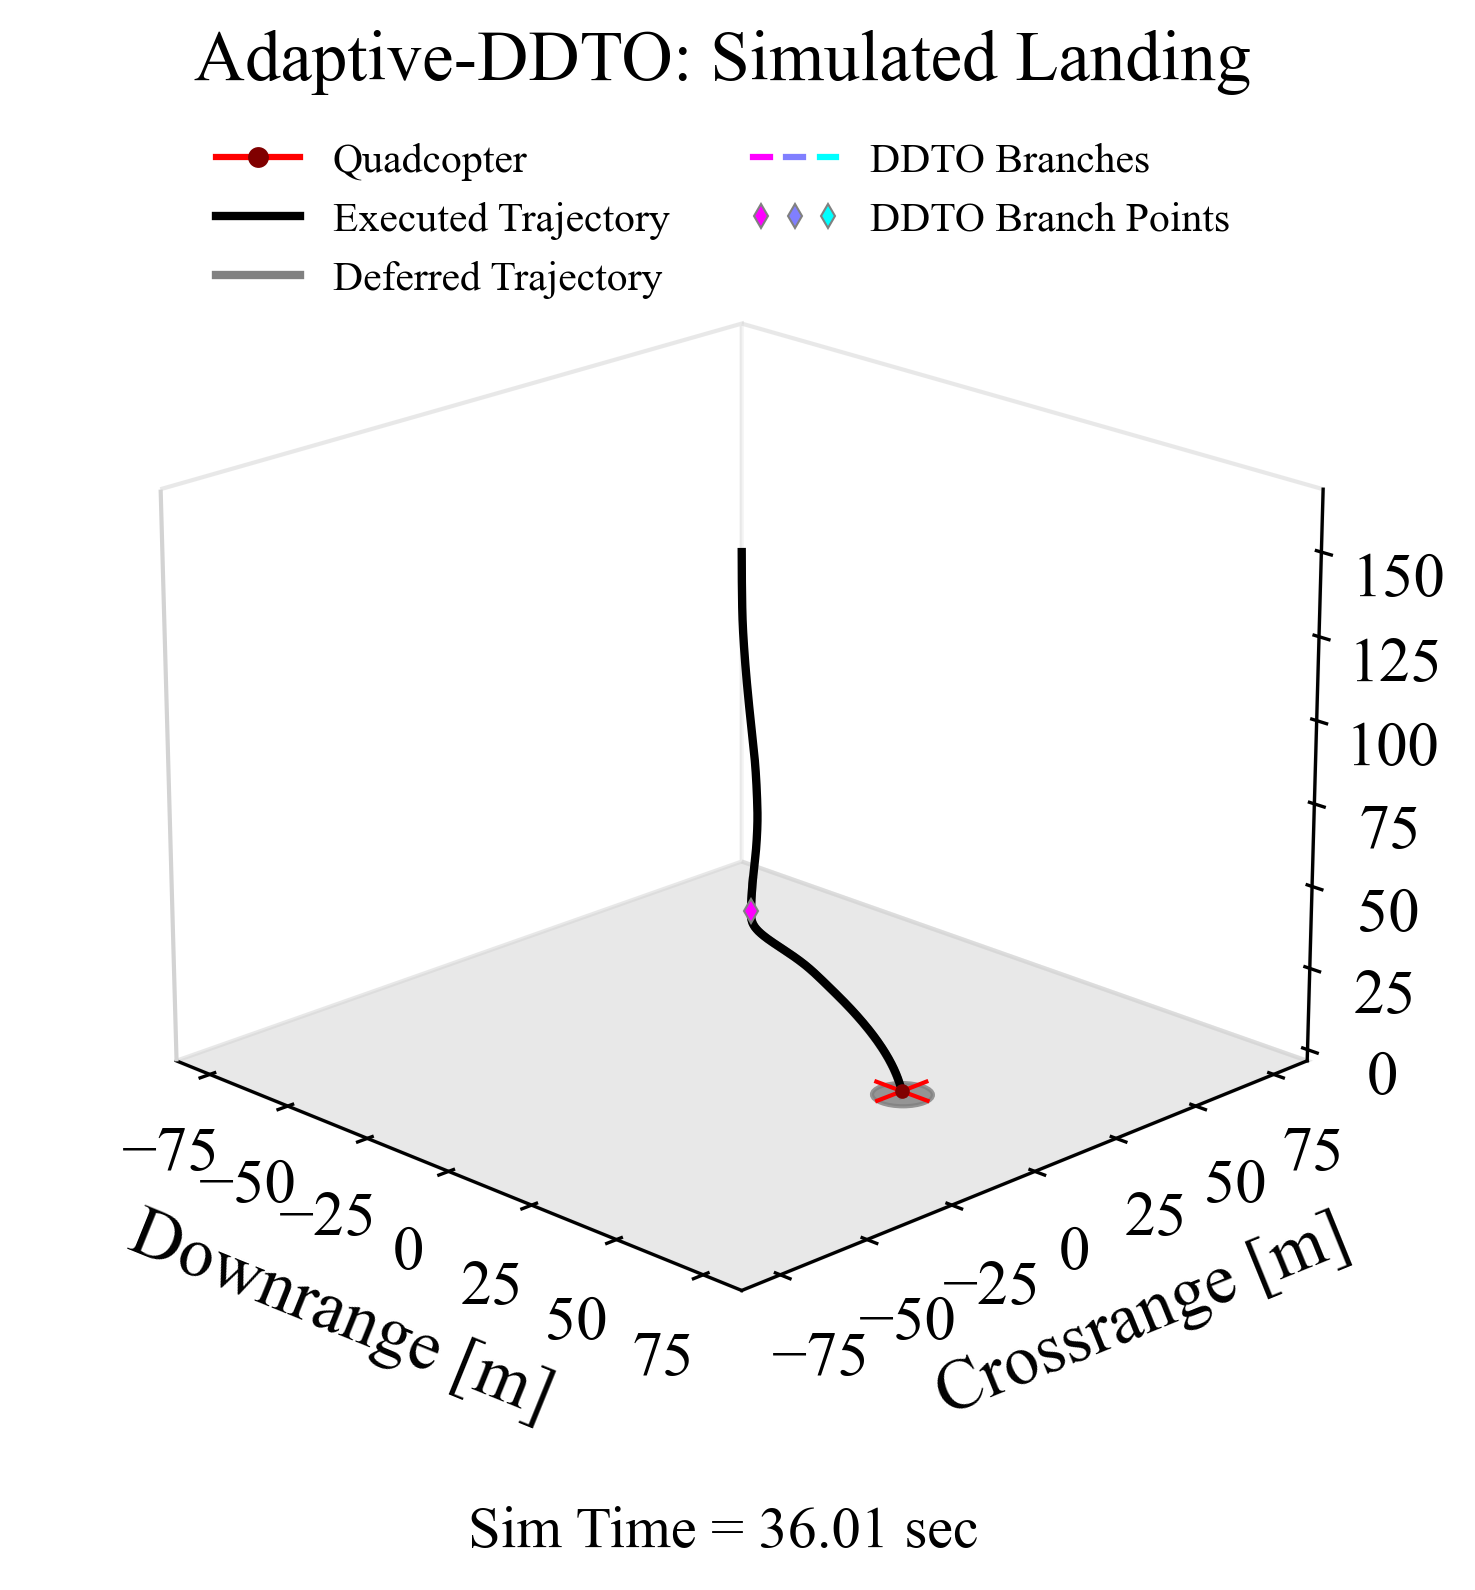

In [15]:
replay_addto_landing(quad, results_sim_sol, results_guid_update_branches, results_guid_update_trajs, results_guid_update_time, results_targs_status, results_targs_radii, view_az=-45)

### Parametric 3D trajectory plot

The following function plots a parametric 3D plot of the landing, with all computed DDTO solutions and their correponding branch sets shown (branches are truncated with a red square marker for ease of visualization).

In [ ]:
plot_addto_parametric_3D_trajectory(quad, results_sim_sol, results_guid_update_branches, results_guid_update_trajs, view_az=-45)

### Time signal history subplot

The following function creates a subplot of various time signal histories of interest (specifically, for commanded thrust, tilt angle to the vertical, and acquired target radii).

In [ ]:
plot_addto_signals_subplot(quad, results_sim_sol, results_targs_radii, results_guid_update_time, guid_lock_time)